In [ ]:
!pip install tensorflow[and-cuda]

In [26]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import math
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [16]:
!ls cats_and_dogs/validation/

cats  dogs


In [17]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                      batch_size=batch_size,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes=["cats", "dogs"],
                                                      class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                    batch_size=batch_size,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes=["cats", "dogs"],
                                                    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(PATH,
                                                        batch_size=batch_size,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        classes=['test'],
                                                        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


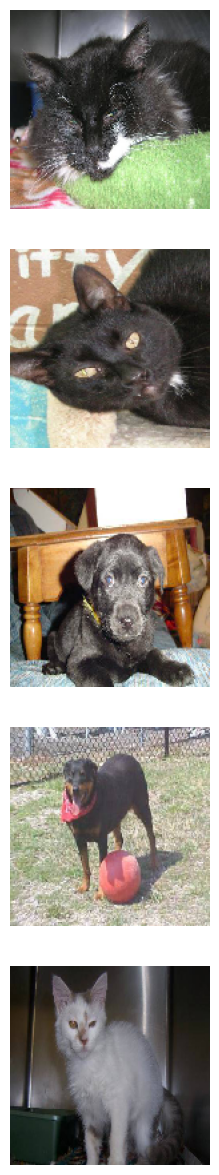

In [18]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [19]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.20,
                                            height_shift_range=.20,
                                            zoom_range=.25,
                                           fill_mode='nearest',
                                            horizontal_flip=True
                                           )


Found 2000 images belonging to 2 classes.


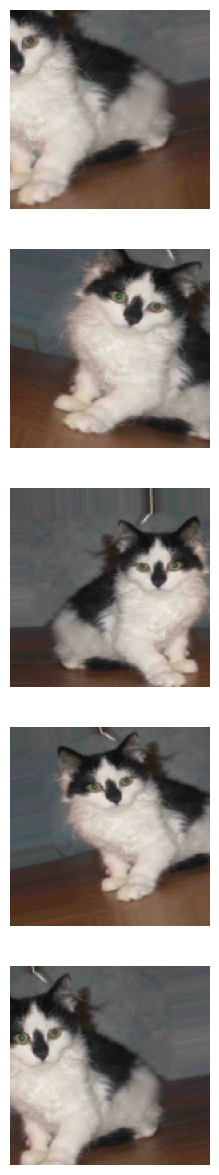

In [20]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [21]:
# 7
model = Sequential()
model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    22,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,523,201 (85.92 MB)

 Trainable params: 22,523,201 (85.92 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 8
history = None
steps_per_epoch = max(1, math.ceil(train_data_gen.samples / batch_size))
validation_steps = max(1, math.ceil(val_data_gen.samples / batch_size))

# Training the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=validation_steps
)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 575ms/step - accuracy: 0.6891 - loss: 0.5812 - val_accuracy: 0.6710 - val_loss: 0.6046
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15


2024-08-16 03:58:57.460687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:58:57.463965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:58:57.464046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.6691 - loss: 0.5933 - val_accuracy: 0.7080 - val_loss: 0.5618
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15


2024-08-16 03:59:11.611854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:11.615257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:11.615342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step - accuracy: 0.7037 - loss: 0.5589 - val_accuracy: 0.6770 - val_loss: 0.5911
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15


2024-08-16 03:59:25.763029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:25.767196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:25.767277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 540ms/step - accuracy: 0.7037 - loss: 0.5627 - val_accuracy: 0.6890 - val_loss: 0.5754
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15


2024-08-16 03:59:39.856193: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-16 03:59:39.856276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:39.856306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step - accuracy: 0.7034 - loss: 0.5535 - val_accuracy: 0.7090 - val_loss: 0.5674
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/15


2024-08-16 03:59:54.012968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:54.013049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693
2024-08-16 03:59:54.016488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 03:59:54.016544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step - accuracy: 0.7184 - loss: 0.5535 - val_accuracy: 0.6940 - val_loss: 0.5624
Epoch 12/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/15


2024-08-16 04:00:08.088373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 04:00:08.088451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 559ms/step - accuracy: 0.7023 - loss: 0.5654 - val_accuracy: 0.7160 - val_loss: 0.5510
Epoch 14/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/15


2024-08-16 04:00:22.220405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11705679140364054665
2024-08-16 04:00:22.224855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11793922622448598693


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step - accuracy: 0.7217 - loss: 0.5558 - val_accuracy: 0.7100 - val_loss: 0.5476


ValueError: x and y must have same first dimension, but have shapes (15,) and (8,)

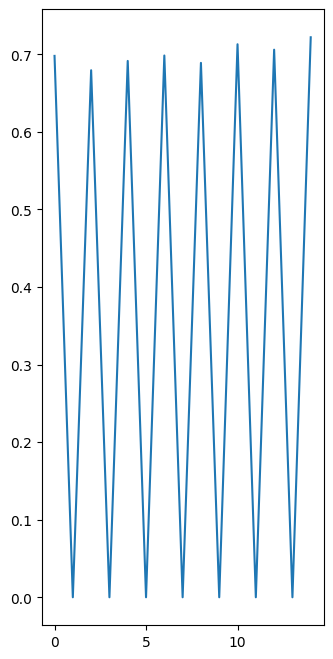

In [36]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
probabilities = model.predict(test_data_gen)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


In [35]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
